# Style Transfer with Convolutional Neural Networks

In [ ]:
import torchvision.models as models
from importlib import reload
import torch
import numpy as np
from torch.optim import LBFGS
import torch.nn as nn
from __future__ import print_function
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd

import matplotlib.pyplot as plt
import pdb
import copy

%matplotlib inline

# Loss functions

In [ ]:
vgg = models.vgg16(pretrained=True)

## Content Loss

### Content Image

In [ ]:
content_image = Variable(U.get_image(3, None))
content_image = content_image.cuda()
U.imshow(content_image.data)

In [ ]:
style_image = Variable(U.get_image(9, 84, None))
style_image = style_image.cuda()
print(style_image.size())
U.imshow(style_image.data)

# Style Loss

In [9]:
style_weights = {
    0: 1000,
    2: 1000,
    5: 1000,
    7: 1000,
    10: 1000
}

class GramMatrix(nn.Module):
    def forward(self, input):
        batch_size, height, width, chan = input.size()
        flattened_channels = input.view(batch_size * height, width * chan)
        #view vs resize here? view used in tutorial
        g_matrix = torch.mm(flattened_channels, flattened_channels.t())
        return g_matrix.div(flattened_channels.nelement())

class StyleLoss(nn.Module):
    def __init__(self, weight, target):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.loss_fn(self.G, self.target)
        return self.output
    
    def backward(self, retain_graph=True):
        #why retain variables here?
        self.loss.backward(retain_graph=retain_graph)
        return self.loss
     

# Content Loss

In [ ]:
content_weights = {
    7: 1,
    14: 3,
    24: 3,    
}


class ContentLoss(nn.Module):
    def __init__(self, weight, target):
        super(ContentLoss, self).__init__()        
        self.target = target.detach()
        self.weight = 1
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        self.loss = self.loss_fn(input * self.weight, self.target)
        self.output = input
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


In [ ]:
#all conv indexes [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
selected_convolutional_indexes = [7, 14, 24]
selected_style_indexes = [0, 2, 5, 7, 10]


def build_model(cnn):
    content_losses = []
    style_losses = []
    model = nn.Sequential()
    cnn = copy.deepcopy(cnn).cuda()
    gram = GramMatrix()
    for index, layer in enumerate(cnn.features):
        #what happens when indexes overlap and module is added twice?
        #Doing the loss after the Conv Layers, what happens if we do it after RELU?
        layer_set = False

        if type(layer) is nn.Conv2d and index in selected_style_indexes:
            layer_set = True
            model.add_module("layer_{}_style".format(index), layer)
            #should I be cloning this?
            style_target = model(style_image.unsqueeze(0)).clone()
            style_loss = StyleLoss(style_weights[index], gram(style_target))
            style_losses.append(style_loss)
            model.add_module("layer_{}_style_loss".format(index), style_loss)
            
        if type(layer) is nn.Conv2d and index in selected_convolutional_indexes:
            layer_set = True
            model.add_module("layer_{}_conv".format(index), layer)
            #should I be cloning this?            
            content_target = model(content_image.unsqueeze(0)).clone()
            content_loss = ContentLoss(content_weights[index], content_target)
            content_losses.append(content_loss)
            model.add_module("layer_{}_content_loss".format(index), content_loss)
            
        if type(layer) is nn.ReLU and index - 1 in selected_style_indexes:
            layer_set = True
            model.add_module("layer_{}_style_relu".format(index ), layer)
            #should I be cloning this?
            style_target = model(style_image.unsqueeze(0)).clone()
            style_loss = StyleLoss(style_weights[index - 1], gram(style_target))
            style_losses.append(style_loss)
            model.add_module("layer_{}_style_loss_relu".format(index), style_loss)
            
        if type(layer) is nn.ReLU and index - 1 in selected_convolutional_indexes:
            layer_set = True
            model.add_module("layer_{}_conv_relu".format(index), layer)
            #should I be cloning this?            
            content_target = model(content_image.unsqueeze(0)).clone()
            content_loss = ContentLoss(content_weights[index - 1], content_target)
            content_losses.append(content_loss)
            model.add_module("layer_{}_content_loss_relu".format(index), content_loss)
                        

        if type(layer) is nn.MaxPool2d:
            layer_set = True
            avg_pool = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding = layer.padding)
            model.add_module("layer_{}".format(index), avg_pool)
        if not layer_set:
            model.add_module("layer_{}".format(index), layer)
    modeul = model.cuda()
    return model, content_losses, style_losses

In [ ]:
model, c_losses, s_losses = build_model(vgg)

In [52]:
import pdb
class Runner():
    def __init__(self, model, optimizer, c_losses, s_losses, size, gen_image):
        self.optimizer = optimizer
        self.model = model
        self.c_losses = c_losses
        self.s_losses = s_losses
        self.size = size
        self.gen_image = gen_image
        self.count = 0
        self.style_loss = 0
        self.content_loss = 0

    def loss_fn(self):
        self.gen_image.data.clamp_(0,1)
        self.optimizer.zero_grad()

        self.count += 1
        prediction = self.gen_image.unsqueeze(0)
        model(prediction)
        
        s_loss = sum([ s.backward() for s in self.s_losses ])
        c_loss = sum([ c.backward() for c in self.c_losses ])
        self.style_loss = s_loss
        self.content_loss = c_loss
        flattened_img = self.gen_image.grad.view(self.gen_image.nelement()).data
        if self.count % 50 == 0:
            max_grad = max(flattened_img)
            min_grad = min(flattened_img)
            print("Max Gradient: {}, Min Gradient: {}".format(max_grad, min_grad))

        return  self.style_loss + self.content_loss


In [53]:
def run_epochs(count, runner, gen_image):
    for i in range(count):
        runner.optimizer.step(runner.loss_fn)
        if i % 10 == 0:
            style_loss = runner.style_loss[0].data[0]
            content_loss = runner.content_loss[0].data[0]
            total = style_loss + content_loss
            print("Epoch #{}# = Style Loss: {}, Content Loss: {}, Total Loss: {}".format(str(i), style_loss, content_loss, total))    
    gen_image.data.clamp_(0,1)

In [54]:
from scipy.optimize import fmin_l_bfgs_b 
noise_tensor = torch.rand(3,224, 224)
gen_image = nn.Parameter(noise_tensor)
gen_image = gen_image.cuda().clone().detach()
gen_image.requires_grad = True
optimizer = LBFGS([gen_image], lr=0.1)
runner = Runner(model, optimizer, c_losses, s_losses, content_image.size(), gen_image)


In [55]:
run_epochs(150, runner, gen_image)

Epoch #0# = Style Loss: 3.4606614112854004, Content Loss: 1.6560596227645874, Total Loss: 5.116721034049988
Max Gradient: 0.0021960281301289797, Min Gradient: -0.002779047703370452
Max Gradient: 0.0017576295649632812, Min Gradient: -0.002392209367826581
Max Gradient: 0.0008308369433507323, Min Gradient: -0.0012240775395184755
Max Gradient: 0.0005287096137180924, Min Gradient: -0.0005210216622799635
Epoch #10# = Style Loss: 0.15062692761421204, Content Loss: 0.3114579916000366, Total Loss: 0.46208491921424866
Max Gradient: 0.00042826164280995727, Min Gradient: -0.00036069771158508956
Max Gradient: 0.00038568826857954264, Min Gradient: -0.0003442443849053234
Max Gradient: 0.00025858014123514295, Min Gradient: -0.00033645398798398674
Max Gradient: 0.00024646648671478033, Min Gradient: -0.000300978688756004
Epoch #20# = Style Loss: 0.1263798028230667, Content Loss: 0.26803961396217346, Total Loss: 0.3944194167852402
Max Gradient: 0.0003135813167318702, Min Gradient: -0.00022565836843568832

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8EF46A57F0>


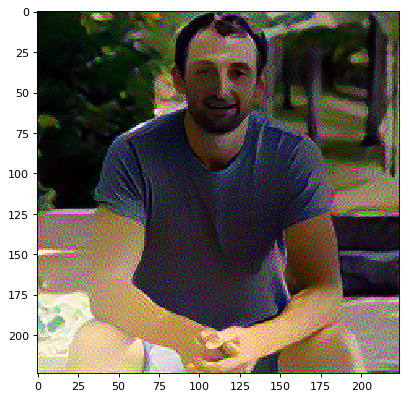

In [56]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8EF47382B0>


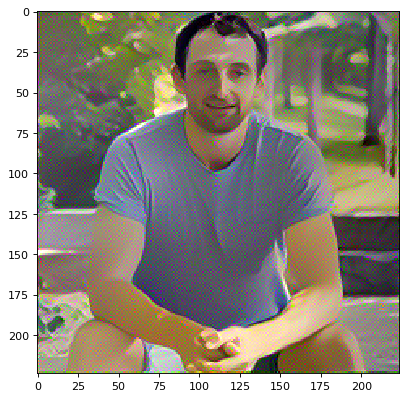

In [48]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8F242D4C18>


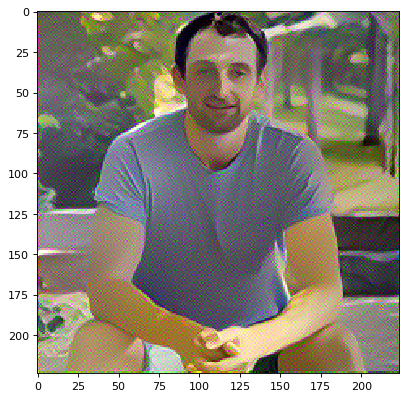

In [38]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F8F18039898>


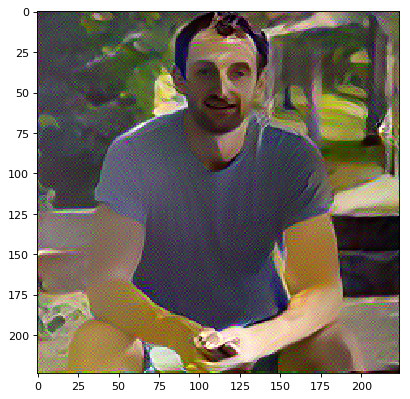

In [25]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F095C461198>


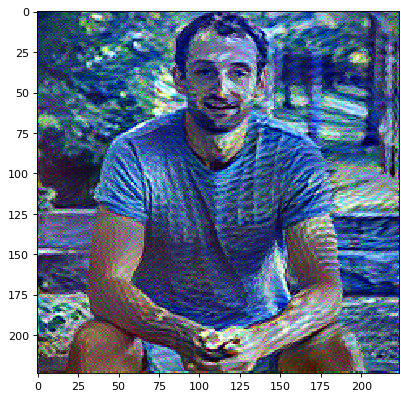

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#print(gen_image.size())
U.imshow(gen_image.data)